In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_380.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_517.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_364.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_258.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_237.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_476.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_563.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_159.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_464.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_518.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_141.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_398.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_442.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_443.jpg
/kaggl

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from tensorflow.keras.regularizers import l2

This project focuses on one of the most classic image classification challenges: distinguishing between images of cats and dogs. Leveraging the power of convolutional neural networks (CNNs) and transfer learning (VGG16), this project explores multiple approaches to achieve high accuracy in classifying images from a dataset containing labeled images of cats and dogs.

This data set is from Kaggle, cats-and-dogs-image-classification.

First of all, I want to ensure the images can be loaded successfully and without any complications. 

In [3]:
#Define the path of train and test folders
train_dir = '/kaggle/input/cats-and-dogs-image-classification/train'
test_dir = '/kaggle/input/cats-and-dogs-image-classification/test'

#Define the path to cat and dog folders
cat_dir_train = os.path.join(train_dir, 'cats')
dog_dir_train = os.path.join(train_dir, 'dogs')

cat_dir_test = os.path.join(test_dir, 'cats')
dog_dir_test = os.path.join(test_dir, 'dogs')

In [4]:
#Image displaying function
def display_images(images, folder, title):
    plt.figure(figsize=(15, 5))
    for i, image_name in enumerate(images):
        image_path = os.path.join(folder, image_name)
        image = Image.open(image_path)
        plt.subplot(1, len(images), i+1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(title)
    plt.show()

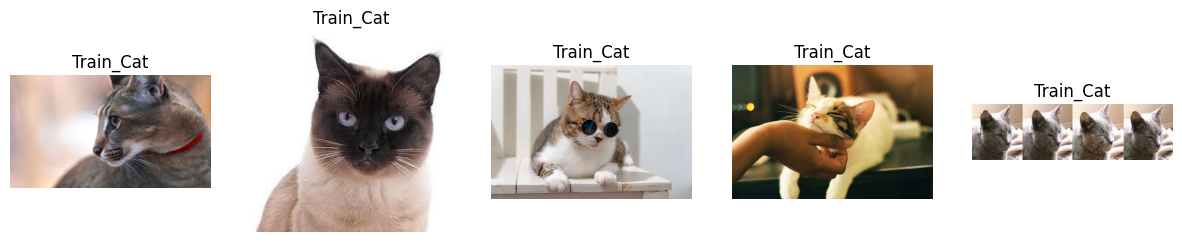

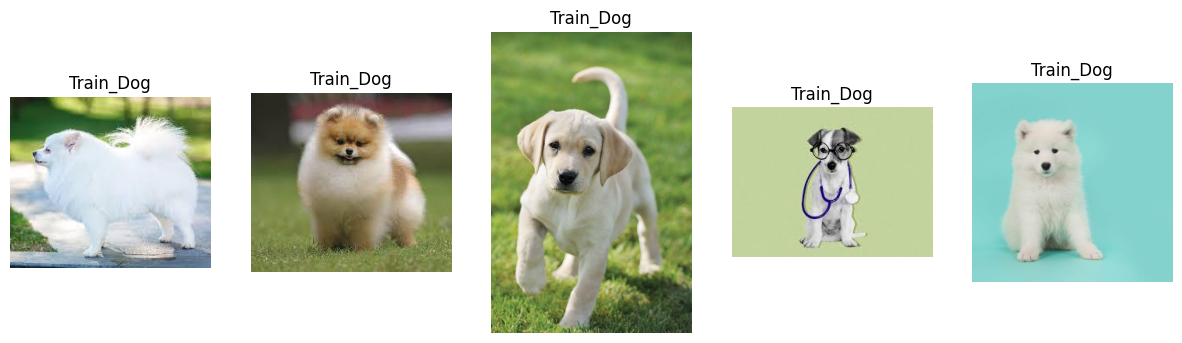

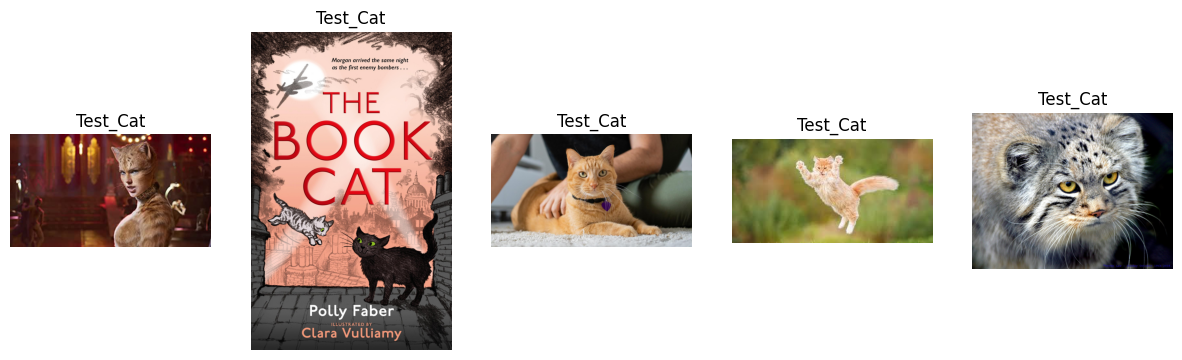

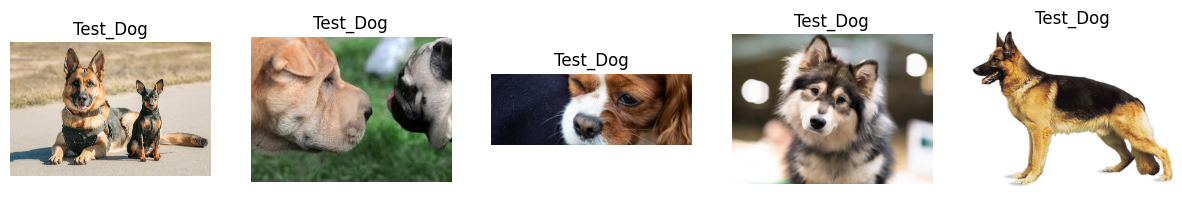

In [5]:
#Display cats and dogs images from train dataset
cat_images_train = os.listdir(cat_dir_train)
dog_images_train = os.listdir(dog_dir_train)

display_images(cat_images_train[:5], cat_dir_train, 'Train_Cat')
display_images(dog_images_train[:5], dog_dir_train, 'Train_Dog')

#Display cats and dogs images from test dataset
cat_images_test = os.listdir(cat_dir_test)
dog_images_test = os.listdir(dog_dir_test)

display_images(cat_images_test[:5], cat_dir_test, 'Test_Cat')
display_images(dog_images_test[:5], dog_dir_test, 'Test_Dog')

It seems like the images can be loaded from the train and test datasets without any complications.
I wonder how many imgages are in the train datasets.

In [6]:
#Checking number of images in train folder
num_cat_images_train = len(cat_images_train)
num_dog_images_train = len(dog_images_train)

print(f"Number of cat images in train folder: {num_cat_images_train}")
print(f"Number of dog images in train folder: {num_dog_images_train}")

Number of cat images in train folder: 279
Number of dog images in train folder: 278


In this step, the dataset is prepared for training and validation. The images are resized to a consistent dimension and normalized to ensure uniform pixel value scaling. To enhance model generalization, data augmentation techniques such as rotation, zooming, shifting, and flipping are applied to the training data. This helps the model become more robust by simulating real-world variability in image orientation and perspective. Separate generators are created for the training and validation datasets, ensuring that the validation data remains untouched by augmentation techniques.

In [7]:
#Set image size and batch size
image_size = (128, 128)
batch_size = 32

#ImageDataGenerator with augentation for train dataset
train_datagen = ImageDataGenerator(
    rescale = 1./ 255,
    validation_split = 0.2,
    rotation_range= 20,
    width_shift_range= 0.2,
    height_shift_range= 0.2,
    shear_range = 0.2,
    zoom_range= 0.2,
    horizontal_flip= True
)

#Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'binary',
    subset = 'training'
)

#Validation generator
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'binary',
    subset = 'validation'
)

Found 447 images belonging to 2 classes.
Found 110 images belonging to 2 classes.


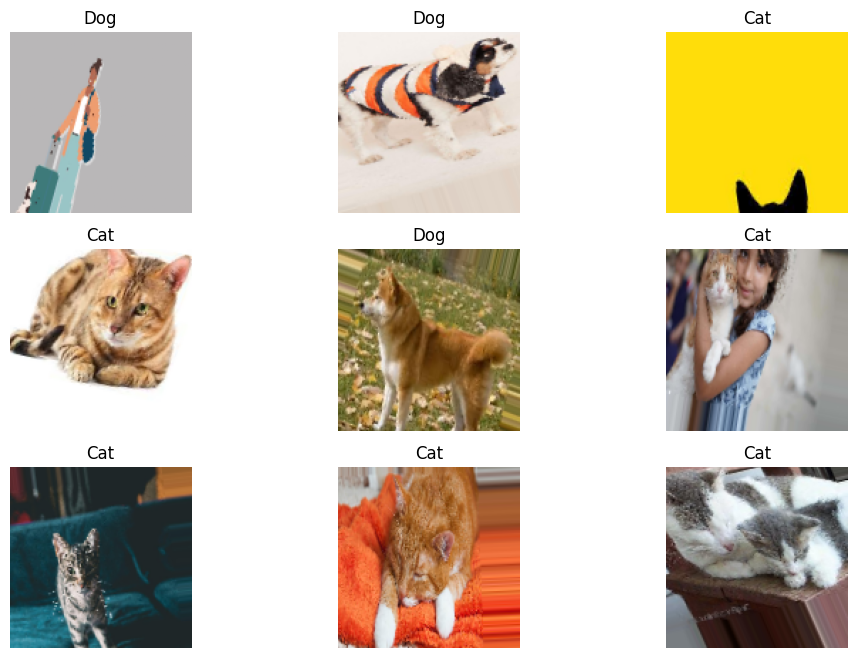

In [8]:
# Display augumented images
images, labels = next(train_generator)

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title('Cat' if labels[i] == 0 else 'Dog')
    plt.axis('off')
plt.show()

The training and validation sets are ready to be trained.

The first model is Custom Convolutional Nerul Network (CNN) model. I chose a Convolutional Neural Network (CNN) for this project because CNNs are specifically designed to handle image data efficiently and effectively. Unlike traditional machine learning models, CNNs automatically learn spatial hierarchies of features, such as edges, textures, and shapes, directly from the image data, eliminating the need for manual feature engineering. They are particularly well-suited for high-dimensional image inputs, as they reduce dimensionality through convolutional and pooling layers without losing critical information. CNNs are robust to spatial variations, allowing them to detect features regardless of their position, which is essential for distinguishing between cats and dogs given the variability in poses, orientations, and backgrounds in the dataset.

In [9]:
# Model 1: Custom Convolutional Neural Network (CNN)

model_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


First convolutional layer = 32 filters, size of 3 by 3 filters, ReLu was chosen for the activation because it helps model
to learn non-linear features.

First Maxpooling reduces the spatial dimensions of the feature map by half and it helps reduce computation and focuses on the most prominent
features.

Second convlutional layer = 64 filters (more filters = extracts higher-level features).

Second Maxpooling reduces the dimensions even more. This makes computations faster and more efficient and only retains most important information
while discarding redundant or less relevant details.

First Dense layer = 128 neurons. This layer learns high-level and more abstract representaions.

Dropout layer randomly drops 50% of the neurons during training to prevent overfitting.

Second Dense layer = single neuron because it's in the output layer for binay classification. Sigmoid as activation because it outputs values
between 0 and 1, which is perfect for binary classification. 

In [10]:
#Compile the CNN model
model_cnn.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

After building up the CNN model, the model is compiled before training with the train dataset images.
Loss was set to binary_coressentropy to measure how well the predicted probabilities match the actual binary labels, which is 0 for cat
and 1 for dog for this project.
Adam was selected as optimizer. Adam combines the benefits of momentum and adaptive learning rates, and also works well for both
small and larget datasets.

In [11]:
#Train the CNN model
history_1 = model_cnn.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 20,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_steps = validation_generator.samples // batch_size
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733730644.449260     106 service.cc:145] XLA service 0x79b8cc006a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733730644.449318     106 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/13 ━━━━━━━━━━━━━━━━━━━━ 1:49 9s/step - accuracy: 0.5625 - loss: 0.6713

I0000 00:00:1733730648.191577     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 668ms/step - accuracy: 0.5228 - loss: 1.7646 - val_accuracy: 0.4688 - val_loss: 0.6933
Epoch 2/20
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4375 - loss: 0.7272

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4375 - loss: 0.7272 - val_accuracy: 0.6429 - val_loss: 0.6835
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.4660 - loss: 0.6998 - val_accuracy: 0.5312 - val_loss: 0.6821
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4375 - loss: 0.7708 - val_accuracy: 0.3571 - val_loss: 0.7175
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step - accuracy: 0.5180 - loss: 0.6871 - val_accuracy: 0.5104 - val_loss: 0.6760
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5000 - loss: 0.6832 - val_accuracy: 0.5714 - val_loss: 0.6939
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.5553 - loss: 0.6750 - val_accuracy: 0.6146 - val_loss: 0.6756
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5938 - loss: 0.6695 - val_accuracy: 0.4286 - val_loss: 0.6930
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - accuracy: 0.5902 - loss: 0.6759 - val_accuracy: 0.5938 - val_loss: 0

In [12]:
#Evaluation
val_loss, val_accuracy = model_cnn.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.6285 - loss: 0.6957
Validation Loss: 0.6717985272407532
Validation Accuracy: 0.6363636255264282


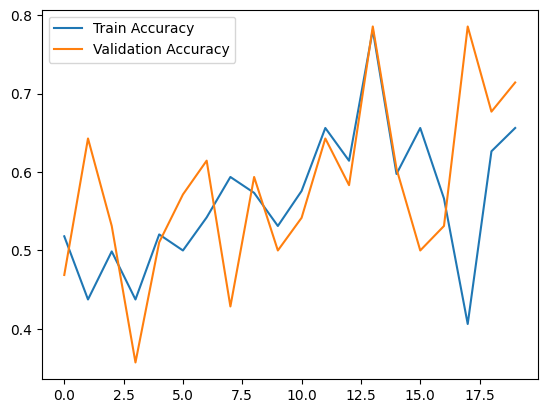

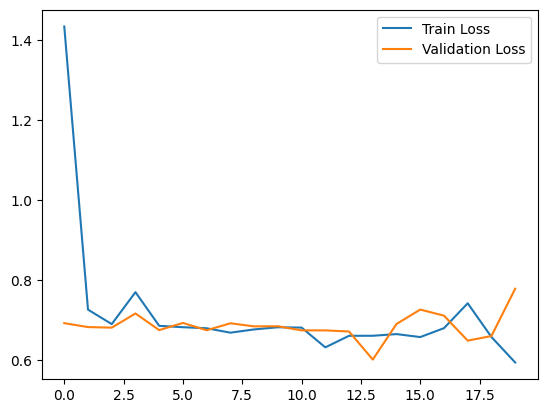

In [13]:
#Visualizing the evaluation 
plt.plot(history_1.history['accuracy'], label='Train Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history_1.history['loss'], label='Train Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [14]:
#CNN model training with epoch = 50
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_2 = model_cnn.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping]
)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 261ms/step - accuracy: 0.6258 - loss: 0.6493 - val_accuracy: 0.5938 - val_loss: 0.6744
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6250 - loss: 0.6373 - val_accuracy: 0.7857 - val_loss: 0.6580
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.6135 - loss: 0.6490 - val_accuracy: 0.6250 - val_loss: 0.6686
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6250 - loss: 0.5946 - val_accuracy: 0.7143 - val_loss: 0.7217
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.6249 - loss: 0.6386 - val_accuracy: 0.6042 - val_loss: 0.7130
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4375 - loss: 0.8486 - val_accuracy: 0.6429 - val_loss: 0.8374
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - accuracy: 0.6183 - loss: 0.6413 - val_accuracy: 0.6667 - val_loss: 0.6938
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6250 - loss: 0.6429 - val_accuracy: 0.5714 -

In [15]:
#Evaluation (CNN model with epoch=50)
val_loss, val_accuracy = model_cnn.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - accuracy: 0.5957 - loss: 0.7410
Validation Loss: 0.7096053957939148
Validation Accuracy: 0.6454545259475708


Epoch stopped at 36 out of 50, which means that the model does not need that high epoch number.

After increasing the number of epoch, validation accuracy slightly improved from 0.64 to 0.65.

I wonder the validation accuracy would improve if I lower the learning rate.
The CNN model used the default, 0.001, but I would like to try out learning_rate= 0.005.

In [16]:
# Learning rate = 0.0005
optimizer = Adam(learning_rate=0.0005)

# Compile the model with the custom optimizer
model_cnn.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

In [17]:
#CNN model training with epoch = 20 & learning rate = 0.0005
history_3 = model_cnn.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping]
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 414ms/step - accuracy: 0.6387 - loss: 0.6246 - val_accuracy: 0.5833 - val_loss: 0.7635
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6250 - loss: 0.6625 - val_accuracy: 0.5000 - val_loss: 0.7642
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step - accuracy: 0.6738 - loss: 0.6241 - val_accuracy: 0.6250 - val_loss: 0.7429
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5938 - loss: 0.5736 - val_accuracy: 0.8571 - val_loss: 0.4855
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.6343 - loss: 0.6070 - val_accuracy: 0.5833 - val_loss: 0.7462
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7188 - loss: 0.5606 - val_accuracy: 0.4286 - val_loss: 0.6720
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.6768 - loss: 0.5740 - val_accuracy: 0.6042 - val_loss: 0.7441
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6875 - loss: 0.5819 - val_accuracy: 0.7143 

In [18]:
#Evaluation (CNN model with epoch=50 & learning rate = 0.0005)
val_loss, val_accuracy = model_cnn.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.6363 - loss: 0.7332
Validation Loss: 0.76445472240448
Validation Accuracy: 0.6090909242630005


Lowering the learning rate from 0.001 to 0.0005 did not really improved the accuracy.

This time, I would like to make this simple CNN model more complex by adding another layer.
Adding another layer may help the model to learn more complex patterns.

In [19]:
# Define the CNN model with additional layers (2 more layers)
model_cnn_complex = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # New layer 1
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # New layer 2
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),  
    Dropout(0.5),                 
    Dense(1, activation='sigmoid')
])

# Compile the model
model_cnn_complex.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Model summary
model_cnn_complex.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,568,321 (5.98 MB)

 Trainable params: 1,568,321 (5.98 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
#CNN model training with 2 more layers
history_4 = model_cnn_complex.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping]
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - accuracy: 0.5332 - loss: 0.7597 - val_accuracy: 0.5208 - val_loss: 0.6927
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5484 - loss: 0.6872 - val_accuracy: 0.3571 - val_loss: 0.6992
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.4971 - loss: 0.6934 - val_accuracy: 0.5208 - val_loss: 0.6929
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4375 - loss: 0.6932 - val_accuracy: 0.3571 - val_loss: 0.6939
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.5284 - loss: 0.6929 - val_accuracy: 0.5208 - val_loss: 0.6920
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4062 - loss: 0.6932 - val_accuracy: 0.3571 - val_loss: 0.6962
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.5196 - loss: 0.6927 - val_accuracy: 0.5312 - val_loss: 0.6926
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5625 - loss: 0.6928 - val_accuracy: 0.4286 - 

In [21]:
#Evaluation (CNN model with epoch=20 & learning rate = 0.0005 & 2 more layers)
val_loss, val_accuracy = model_cnn_complex.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.5156 - loss: 0.6932
Validation Loss: 0.6937374472618103
Validation Accuracy: 0.5


Adding more layers did not really help improving the validation accuracy.

This time, I am going to perform hyperparameter search using KerasTuner's RandomSearch.

In [24]:
#KerasTuner Hyperparameter Search
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('filters', 32, 128, step=32), (3, 3), activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(hp.Int('units', 32, 128, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',   
    max_trials=20,              
    executions_per_trial=1,     
    directory='my_dir',
    project_name='cnn_tuning'
)


tuner.search(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best number of filters: {best_hps.get('filters')}")
print(f"Best number of units: {best_hps.get('units')}")
print(f"Best dropout rate: {best_hps.get('dropout')}")

Trial 20 Complete [00h 00m 56s]
val_accuracy: 0.7142857313156128

Best val_accuracy So Far: 0.9285714030265808
Total elapsed time: 00h 19m 29s
Best number of filters: 32
Best number of units: 96
Best dropout rate: 0.30000000000000004


In [25]:
# Build the best model
model_cnn_best_hps = tuner.hypermodel.build(best_hps)

# Train the best model 
history_5 = model_cnn_best_hps.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20, 
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 364ms/step - accuracy: 0.4672 - loss: 6.9912 - val_accuracy: 0.5000 - val_loss: 1.1190
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4688 - loss: 2.2905 - val_accuracy: 0.6429 - val_loss: 0.9510
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - accuracy: 0.4764 - loss: 1.2796 - val_accuracy: 0.4792 - val_loss: 0.7129
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5625 - loss: 0.6984 - val_accuracy: 0.5714 - val_loss: 0.7312
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.5442 - loss: 0.7295 - val_accuracy: 0.5833 - val_loss: 0.6909
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4062 - loss: 0.7119 - val_accuracy: 0.6429 - val_loss: 0.6822
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step - accuracy: 0.6092 - loss: 0.6766 - val_accuracy: 0.5417 - val_loss: 0.6716
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5938 - loss: 0.6961 - val_accuracy: 0.5000 - 

In [26]:
#Evaluation (CNN model with best hyperparameters)
val_loss, val_accuracy = model_cnn_best_hps.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - accuracy: 0.5947 - loss: 0.6841
Validation Loss: 0.6831413507461548
Validation Accuracy: 0.6272727251052856


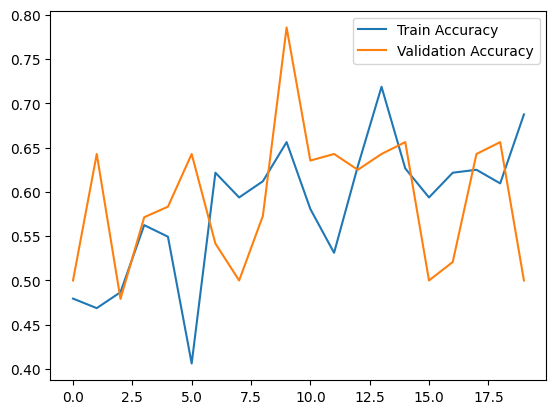

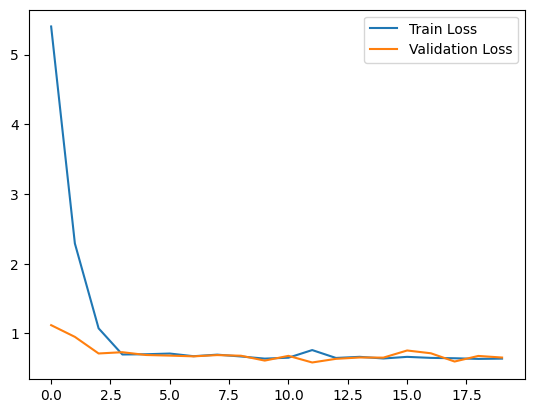

In [27]:
#Visualizing the evaluation (CNN model with best hyperparameters)
plt.plot(history_5.history['accuracy'], label='Train Accuracy')
plt.plot(history_5.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history_5.history['loss'], label='Train Loss')
plt.plot(history_5.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

Even training the CNN model with the best hyperparameters improved the validation accuracy did not improve the accuracy.

I am going to try one last thing before building a new deep learning model. It is adding L2 Regularization in the CNN model with the
best hyperparameters. L2 helps reduce overfitting and encourages the model to generalize better on unseen data.

In [28]:
# CNN model with the best hyperparameters & L2 regularization
model_cnn_best_hps_l2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l2(0.01)),
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(96, activation='relu', kernel_regularizer=l2(0.01)),  
    Dropout(0.3),  
    Dense(1, activation='sigmoid')  
])

# Compile the model
model_cnn_best_hps_l2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#Train the CNN model with the best hyperparameters & L2 regularization
history_6 = model_cnn_best_hps_l2.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20, 
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 393ms/step - accuracy: 0.5046 - loss: 2.5866 - val_accuracy: 0.5000 - val_loss: 1.4483
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3750 - loss: 1.4712 - val_accuracy: 0.5000 - val_loss: 1.4159
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.5202 - loss: 1.3519 - val_accuracy: 0.5312 - val_loss: 1.1600
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4688 - loss: 1.1634 - val_accuracy: 0.2857 - val_loss: 1.1651
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.5471 - loss: 1.0950 - val_accuracy: 0.6146 - val_loss: 0.9838
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5625 - loss: 0.9854 - val_accuracy: 0.5000 - val_loss: 0.9870
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.5971 - loss: 0.9572 - val_accuracy: 0.5625 - val_loss: 0.8976
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5625 - loss: 0.9007 - val_accuracy: 0.5000 

In [29]:
#Evaluation (CNN model with best hyperparameters)
val_loss, val_accuracy = model_cnn_best_hps_l2.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - accuracy: 0.4677 - loss: 1.4577
Validation Loss: 1.4470857381820679
Validation Accuracy: 0.5


Adding L2 Regularization did not help at all. It seems like overfitting was not the problem here.
The hihgest validation accuracy was 0.65 when the epoch was increased from 20 to 50.

The validation accuracies from the CNN models are lower than I expected so, I would like try Transfer Learning, which uses pre-trained model VGG16. VGG16 is trained on large datasets such ImageNet so this can tell me how well deep learning model can perform with this dataset.
Here is my 2nd deep learning model.

In [30]:
# Load the VGG16 model w/out the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the pre-trained layers
base_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


include_top = False, this means that when I load VGG16 model, I loaded it without its top classification layer.
It's because the output of the top layer is 1000 dimensional vector but I only need 2 classes(cat and dog) so I loaded the model
without the top layer.

The reason why I froze the pre-trained layers is the pre-trained layers of VGG16 has already learned features from ImageNet dataset
so freezing ensures that those features are not overwritten during training on my cat and dog dataset.
Compare to the data on ImageNet, my cat and dog dataset is way smaller, so if VGG16 is overwritten by my small dataset, the model
might no longer effectively recognnize patterns that are universally useful and instead, it will be over-specialized in my dataset. 


In [31]:
# Add custom layers on top
x = Flatten()(base_model.output)           
x = Dense(128, activation='relu')(x)       
x = Dropout(0.5)(x)                        
output = Dense(1, activation='sigmoid')(x) 

# Combine the base model with the new custom layers
model_vgg16 = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_vgg16.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
model_vgg16.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,521 (60.13 MB)

 Trainable params: 1,048,833 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

So, I used VGG16 as feature extractor and added custom layers like dense layer and droupout.

I compiled this model just like how I did previous 2 CNN models.

Non-trainable params number is pretty high, 14,714,688, because the base model (VGG16) has been trained on Imagenet and
its weights are not updated with my data.

In [32]:
#Train transfer_learning model (VGG16)
history_transfer = model_vgg16.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 632ms/step - accuracy: 0.5683 - loss: 1.0214 - val_accuracy: 0.7292 - val_loss: 0.5548
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.7188 - loss: 0.5768 - val_accuracy: 0.4286 - val_loss: 0.8277
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.7052 - loss: 0.5590 - val_accuracy: 0.7292 - val_loss: 0.5214
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8438 - loss: 0.4702 - val_accuracy: 0.7143 - val_loss: 0.5244
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.7999 - loss: 0.4490 - val_accuracy: 0.7708 - val_loss: 0.4449
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7419 - loss: 0.4510 - val_accuracy: 0.7857 - val_loss: 0.3924
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step - accuracy: 0.7793 - loss: 0.4503 - val_accuracy: 0.7708 - val_loss: 0.4713
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7742 - loss: 0.4561 - val_accuracy: 0.8571

In [33]:
#Evaluation
val_loss, val_accuracy = model_vgg16.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - accuracy: 0.7773 - loss: 0.4524
Validation Loss: 0.4748990535736084
Validation Accuracy: 0.7636363506317139


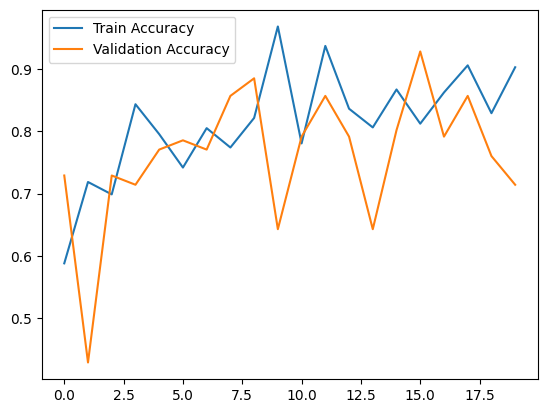

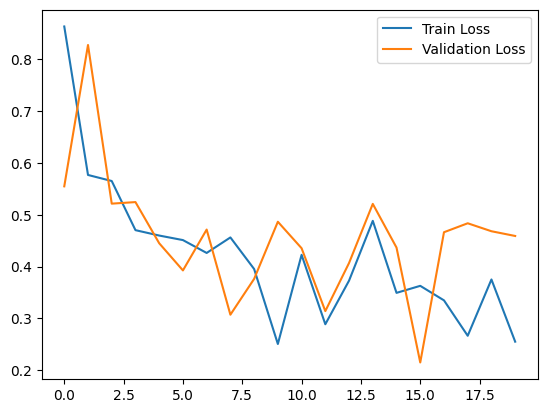

In [34]:
#Visualizing the evaluation 
plt.plot(history_transfer.history['accuracy'], label='Train Accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history_transfer.history['loss'], label='Train Loss')
plt.plot(history_transfer.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

Validation accuracy is 0.76 which is way higher than the CNN model.
Also, the trend of accruacy plot is increasing as epoch increases and decreasing in loss as epoch increases. This is what I was expected to see if a deep learning model is propperly trained.

In [35]:
#VGG16 model with lower learning rate
model_vgg16.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

history_transfer_2 = model_vgg16.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 407ms/step - accuracy: 0.8418 - loss: 0.3499 - val_accuracy: 0.7917 - val_loss: 0.4535
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8750 - loss: 0.2390 - val_accuracy: 0.8571 - val_loss: 0.2596
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.8635 - loss: 0.3160 - val_accuracy: 0.7396 - val_loss: 0.4553
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9375 - loss: 0.1491 - val_accuracy: 0.8571 - val_loss: 0.3658
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.8596 - loss: 0.3161 - val_accuracy: 0.7917 - val_loss: 0.4262
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9062 - loss: 0.3020 - val_accuracy: 0.7857 - val_loss: 0.4460
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.8858 - loss: 0.2952 - val_accuracy: 0.8438 - val_loss: 0.3127
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8750 - loss: 0.2723 - val_accuracy: 0.7857 

In [36]:
#Evaluation
val_loss, val_accuracy = model_vgg16.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.7742 - loss: 0.4323
Validation Loss: 0.4166701138019562
Validation Accuracy: 0.7818182110786438


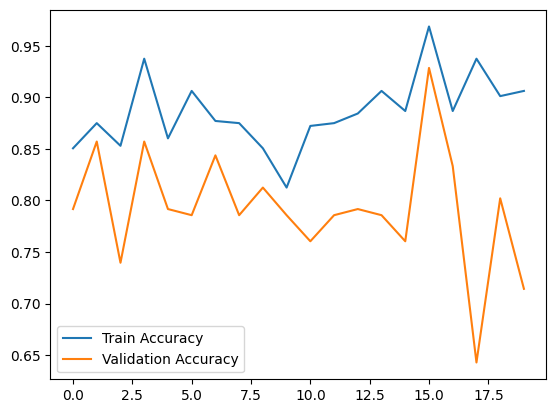

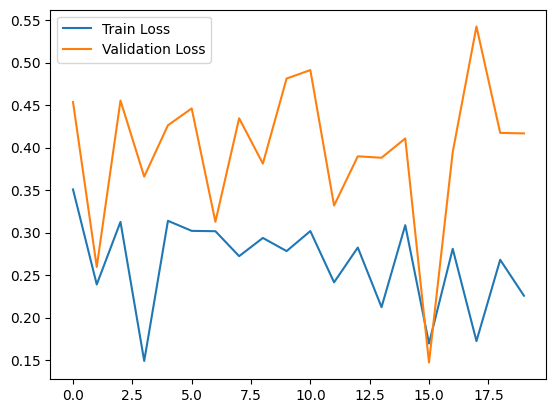

In [37]:
#Visualizing the evaluation 
plt.plot(history_transfer_2.history['accuracy'], label='Train Accuracy')
plt.plot(history_transfer_2.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history_transfer_2.history['loss'], label='Train Loss')
plt.plot(history_transfer_2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

The validation accruacy is 0.78 and this is the highest validation accuracy out of all, including the CNN models.
I wonder if increaseing epoch will improve the accruacy even more.

In [38]:
#VGG16 model with learning rate = 0.0001 & epoch = 50
history_transfer_3 = model_vgg16.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 265ms/step - accuracy: 0.8442 - loss: 0.3252 - val_accuracy: 0.8333 - val_loss: 0.3504
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9062 - loss: 0.2715 - val_accuracy: 0.8571 - val_loss: 0.3898
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.9080 - loss: 0.2455 - val_accuracy: 0.7604 - val_loss: 0.4402
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8125 - loss: 0.3818 - val_accuracy: 0.9286 - val_loss: 0.2876
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.8508 - loss: 0.3156 - val_accuracy: 0.8333 - val_loss: 0.3977
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9062 - loss: 0.2227 - val_accuracy: 0.7143 - val_loss: 0.4288
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.8734 - loss: 0.2767 - val_accuracy: 0.8021 - val_loss: 0.3686
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9062 - loss: 0.2091 - val_accuracy: 0.7143 - 

In [39]:
#Evaluation
val_loss, val_accuracy = model_vgg16.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - accuracy: 0.7601 - loss: 0.5122
Validation Loss: 0.47463202476501465
Validation Accuracy: 0.7909091114997864


I was hoping to get over 0.90 but it actually increased only by 1% which is 0.79.
Out of all the CNN and VGG16 models that I have trained so far, the highest validation accuracy is from VGG16 with learning rate = 0.0001 and epoch = 50.

This is my final model that I am going to classify the test data.

In [40]:
#Test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Create an ImageDataGenerator for testing (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),  
    batch_size=32,          
    class_mode='binary',     
    shuffle=False           
)

Found 140 images belonging to 2 classes.


In [41]:
#Evaluation (Test Data)
test_loss, test_accuracy = model_vgg16.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7812 - loss: 0.4857

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 728ms/step - accuracy: 0.7641 - loss: 0.4775
Test Loss: 0.5064
Test Accuracy: 0.7429


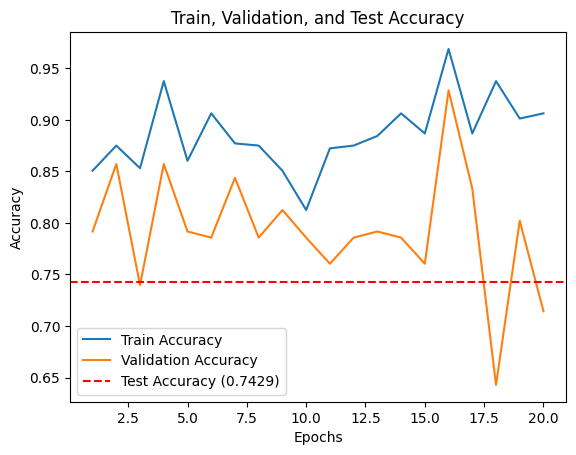

In [42]:
# Extract training and validation accuracy (VGG16 model with learning rate = 0.0001)
train_accuracy = history_transfer_2.history['accuracy']
val_accuracy = history_transfer_2.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

# Plot training and validation accuracy
plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')

# Add test accuracy as a horizontal line
plt.axhline(y=test_accuracy, color='r', linestyle='--', label=f'Test Accuracy ({test_accuracy:.4f})')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train, Validation, and Test Accuracy')
plt.legend()
plt.show()

The accruacy for the test dataset is 0.74.

The graph shows that the model could have overfitted with the training dataset.

Conclusion: The Convolutional Neural Network (CNN) model for classifying cats and dogs was thoroughly optimized through various hyperparameter tuning experiments. These included increasing the number of training epochs from 20 to 50, lowering the learning rate to 0.0005 for improved convergence, adding two additional Conv2D layers to increase feature extraction capacity, performing a hyperparameter search with KerasTuner, and incorporating L2 regularization to mitigate overfitting. Despite these efforts, the validation accuracy remained moderate, with the best configuration identified by KerasTuner achieving a validation accuracy of only 65%.

These results suggest that the custom CNN model struggled to generalize effectively, potentially due to limitations in dataset size, variability, or model complexity. The moderate performance underscores the challenges of designing a CNN model from scratch for this task.

In contrast, the VGG16 model demonstrated significantly better performance, achieving a validation accuracy of over 80%. This was achieved through hyperparameter tuning, which included lowering the learning rate and increasing the training epochs from 20 to 50. Leveraging the pre-trained weights of VGG16 enabled the model to transfer knowledge from the large-scale ImageNet dataset, overcoming the limitations of dataset size and diversity. Based on its superior validation accuracy, the VGG16 model was selected for classifying the test dataset, where it also demonstrated robust generalization.

This project underscores the importance of transfer learning for achieving high performance on tasks with moderate-sized datasets. It highlights how pre-trained models like VGG16 can significantly outperform custom architectures by leveraging prior knowledge. Future work could include fine-tuning additional layers of VGG16, exploring other pre-trained architectures, or further augmenting the dataset for enhanced generalization.